# Timestructure (spill, schottky)

For some applications it is important to consider the particle arrival time, taking the longitudinal coordinate `zeta` into account.
This includes non-circular lines, characterisation of extracted particle spills or long-term studies of coasting beams.
The particle arrival time is:

\begin{equation*}
t = \frac{\text{at_turn}}{f_\text{rev}} - \frac{\text{zeta}}{\beta_0 c_0}
\end{equation*}

where the first term is only relevant for circular lines. 

The plots in this guide are all based on the particle arrival time.

In [1]:
%load_ext autoreload
%autoreload 2

import xtrack as xt
import xpart as xp
import xplt
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

xplt.apply_style()

np.random.seed(43543557)

In [2]:
## Generate a simple 6-fold symmetric FODO lattice

n = 6  # number of sections
elements = {
    "QF": xt.Multipole(length=0.3, knl=[0, +0.63]),
    "QD": xt.Multipole(length=0.3, knl=[0, -0.48]),
    "MU": xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
}
parts = {
    "a": [xt.Node(0.7, "QF"), xt.Node(1.4, "MU"), xt.Node(2.1, "QD"), xt.Node(2.8, "MU")],
    "b": [xt.Node(2.2, "MU"), xt.Node(2.9, "QD"), xt.Node(3.6, "MU"), xt.Node(4.3, "QF")],
}
nodes = [xt.Node(5.0 * i, "a" if i % 2 else "b", name=f"S{i+1}") for i in range(n)]

# sextupoles
for i in range(n):
    sx = xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))])
    nodes.append(xt.Node(0.2, sx, from_=f"S{i+1}", name=f"S{i+1}SX"))

# aperture
nodes.append(xt.Node(0, xt.LimitRect(min_x=-0.01, max_x=0.01), name="APERTURE"))

line = xt.Line.from_sequence(
    nodes, length=5.0 * n, sequences=parts, elements=elements, auto_reorder=True
)
line.particle_ref = xp.Particles()
line.build_tracker();

Found suitable prebuilt kernel `default_only_xtrack`.


In [3]:
## Generate particles
nparticles = int(1e4)

# Transverse distribution (gaussian)
norm_emitt_x = 3e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_x)
norm_emitt_y = 4e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_y)
x, px = xp.generate_2D_gaussian(nparticles)
y, py = xp.generate_2D_gaussian(nparticles)

# Longitudinal distribution (coasting beam)
rel_momentum_spread = 1e-4  # relative momentum spread ( P/p0 - 1 )
zeta = line.get_length() * np.random.uniform(-0.5, 0.5, nparticles)
delta = rel_momentum_spread * xp.generate_2D_gaussian(nparticles)[0]

particles = line.build_particles(
    x_norm=x,
    px_norm=px,
    nemitt_x=norm_emitt_x,
    y_norm=y,
    py_norm=py,
    nemitt_y=norm_emitt_y,
    method="4d",  # for twiss (default is 6d, won't work without a cavity)
    zeta=zeta,
    delta=delta,
)

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [4]:
## Twiss
tw = line.twiss(method="4d")

## Track
line.track(particles, num_turns=500, turn_by_turn_monitor=True)

## Scatter over time

The `TimePlot` allows to plot any particle property as function of time. Here we plot `x` and `y` when the particles are lost.

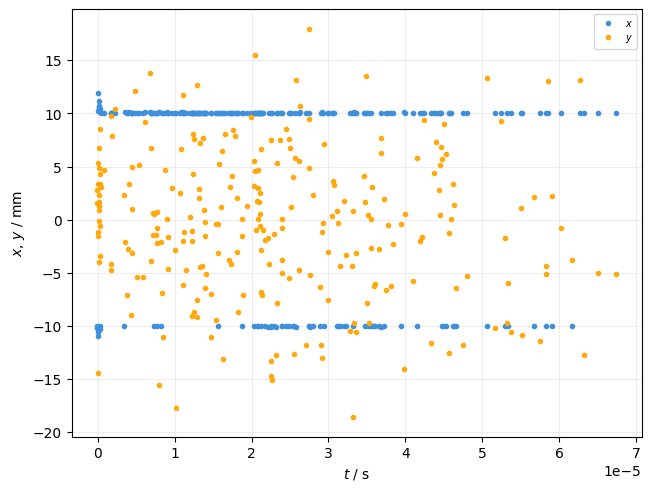

In [5]:
plot = xplt.TimePlot(particles, "x+y", mask=particles.state <= 0, twiss=tw)

## Binned time series

The `TimeBinPlot` allows to plot particle counts or averaged properties as time series with a given resolution.  
Thereby all particles arriving within the interval defined by the time resolution are counted or averaged over.  
The time resolution can be given with the `bin_time` keyword argument.

### Spill intensity
Plot number of lost particles as function of time of slow extraction

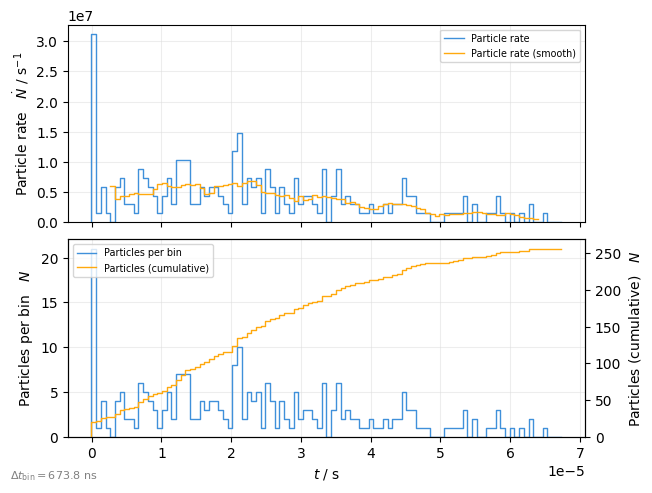

In [6]:
plot = xplt.TimeBinPlot(
    particles,
    "rate+smooth(rate,n=10),count-cumulative",  # rate of, count and cumulative particle count per bin
    mask=particles.state <= 0,  # lost particles
    twiss=tw,
)

### Transverse beam position (BPM)
Plot average y-position as function of time

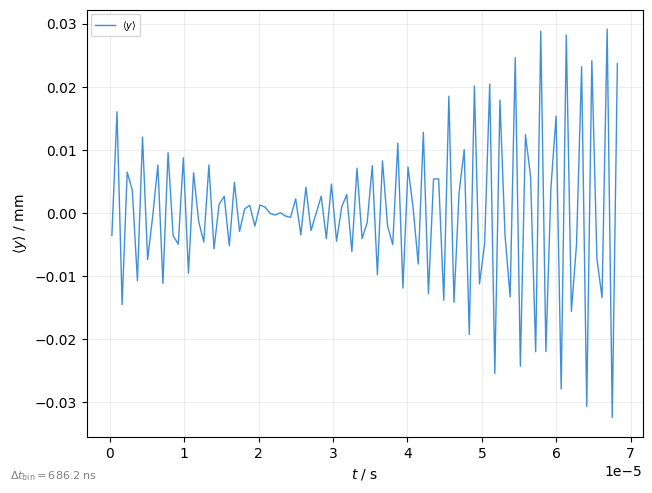

In [7]:
plot = xplt.TimeBinPlot(
    line.record_last_track,
    "y",  # y-position
    # moment=1,  # the average (this is the default anyways)
    twiss=tw,
)

### Longitudinal bunch shape 
Plot charge as function of time

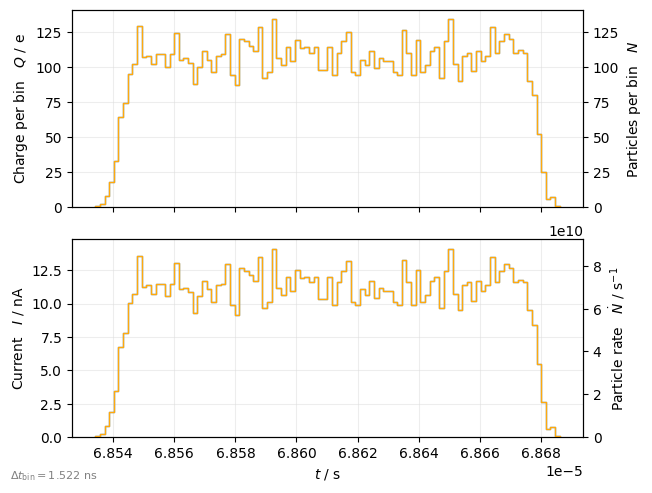

In [8]:
plot = xplt.TimeBinPlot(
    particles, "charge-count,current-rate", twiss=tw, mask=particles.state > 0  # alive particles
)
plot.legend(show=False)

## Spill quality

The following metrices exists to quantify the fluctuation of particle numbers in the respective bins:
- `cv`: Coefficient of variation
- `duty`: Spill duty factor
- `maxmean`: Maximum to mean ratio

These are useful to assess the spill quality.

Plot a metric as function of time in the spill

/mnt/d/pniederm/Hessenbox/GSI/Particle-Tracking/xplot/xplt/timestructure.py:693: RuntimeWarning: invalid value encountered in divide
  F = np.mean(N, axis=axis) ** 2 / np.mean(N**2, axis=axis)
/mnt/d/pniederm/Hessenbox/GSI/Particle-Tracking/xplot/xplt/timestructure.py:694: RuntimeWarning: divide by zero encountered in divide
  F_poisson = 1 / (1 + 1 / np.mean(N, axis=axis))
/mnt/d/pniederm/Hessenbox/GSI/Particle-Tracking/xplot/xplt/timestructure.py:724: RuntimeWarning: divide by zero encountered in divide
  duty2cv = lambda du: factor_cv * (factor_duty / du - 1) ** 0.5
/mnt/d/pniederm/Hessenbox/GSI/Particle-Tracking/xplot/xplt/timestructure.py:724: RuntimeWarning: invalid value encountered in sqrt
  duty2cv = lambda du: factor_cv * (factor_duty / du - 1) ** 0.5


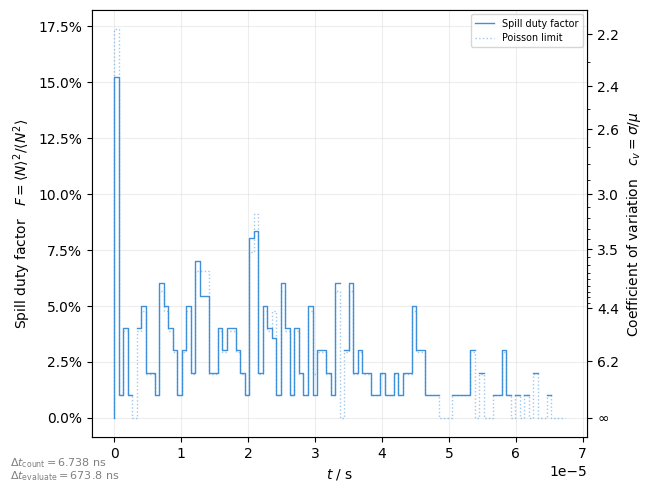

In [9]:
plot = xplt.TimeVariationPlot(
    particles,
    "duty",
    mask=particles.state <= 0,  # only lost particles
    twiss=tw,
    counting_dt=None,  # bin time for particle counting (detector resolution)
    evaluate_dt=None,  # bin time to evaluate metric
)

Plot a metric as function of timescale (counting bin time)

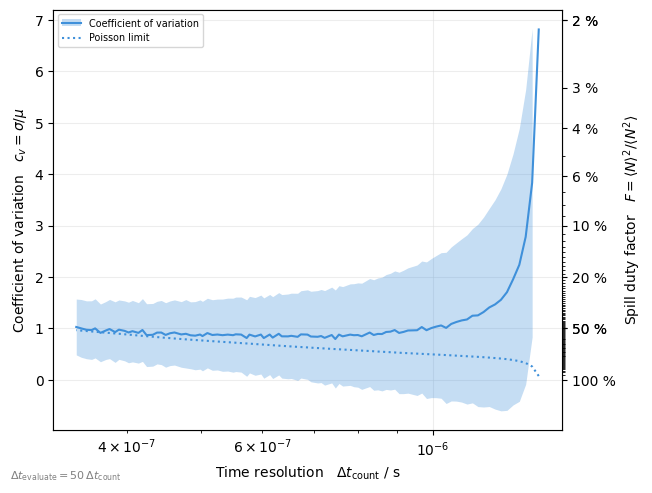

In [10]:
plot = xplt.TimeVariationScalePlot(particles, "cv", twiss=tw)

Make a custom spill quality plot

/home/pniederm/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/pniederm/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


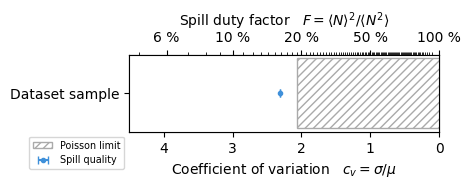

In [11]:
dt_count = 50e-9
bins = 1000
dt_evaluate = dt_count * bins

# use helper to calculate metric
helper = xplt.TimeBinMetricHelper(twiss=tw)
t_min, dt_count, counts = helper.binned_timeseries(particles, dt_count, mask=particles.state <= 0)
Cv, Cv_poisson = helper.calculate_metric(counts, "cv", bins)

# plot it
fig, ax = plt.subplots(figsize=(4, 1), constrained_layout=True)
style = dict(marker=".", ls="", capsize=3, label="Spill quality")
ax.errorbar(np.nanmean(Cv), ["Dataset sample"], xerr=np.nanstd(Cv), **style)
style = dict(hatch="////", ec="#aaa", fc="none", label="Poisson limit")
ax.add_patch(mpl.patches.Rectangle((np.nanmean(Cv_poisson), -0.15), -10, 0.3, **style))
ax.set(xlim=(4.5, 0))

# use helper to style axes
helper._link_cv_duty_axes(ax, ax.twiny(), True, "x")
ax.legend(loc="upper right", bbox_to_anchor=(0, 0));

## Consecutive particle delay

The `TimeIntervalPlot` allows analysis of the delay between consecutive particles.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


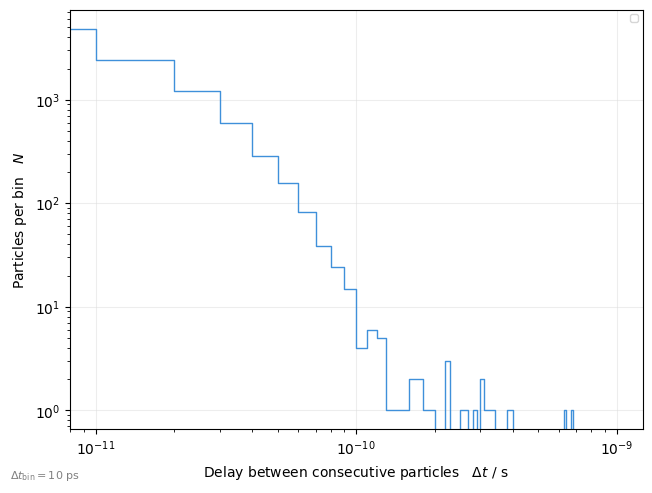

In [12]:
plot = xplt.TimeIntervalPlot(particles, dt_max=1e-9, log=True, twiss=tw)

## Frequency domain

The `TimeFFTPlot` allows frequency analysis of particle data. Therefore the data is first binned into an equidistant time series as described above, and then an FFT is performed. This allows to plot the frequency spectrum of particle arrival time:

### Spill fluctuations

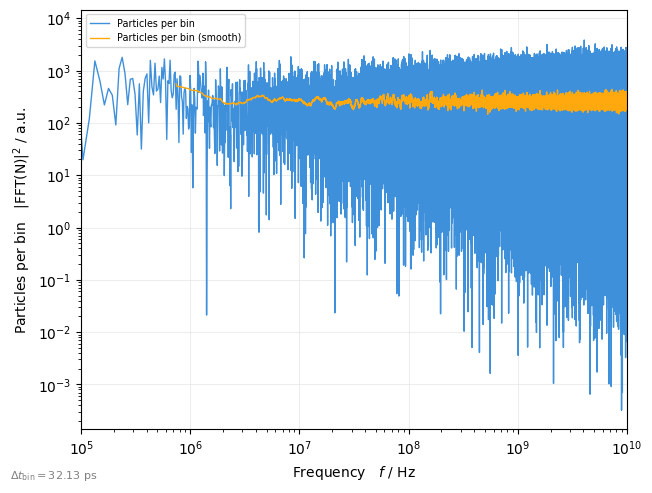

In [13]:
plot = xplt.TimeFFTPlot(
    particles,
    "count+smooth(count,n=100)",
    mask=particles.state <= 0,  # only lost particles
    fmax=1e10,
    log=True,
    twiss=tw,
)
plot.ax.set(xlim=(1e5, None));

### Longitudinal schottky spectrum

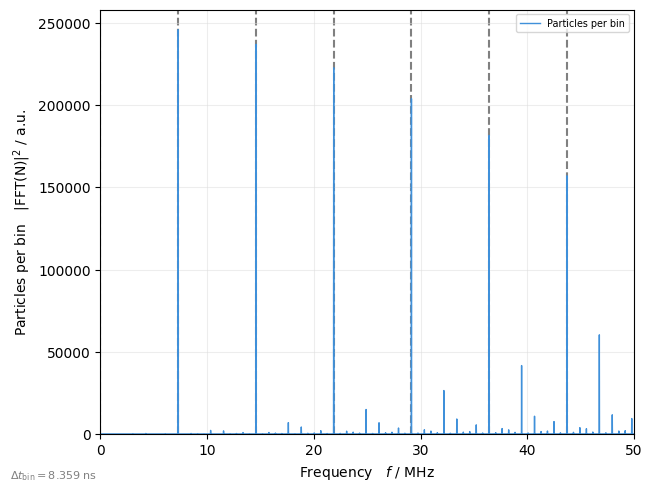

In [14]:
# select only a single particle
mask = (0, None)

plot = xplt.TimeFFTPlot(
    line.record_last_track,
    "count",
    mask=mask,
    fmax=50e6,
    log=False,
    display_units=dict(f="MHz"),
    twiss=tw,
)

frev = 1 / tw.T_rev0
for i in range(10):
    plot.ax.axvline(i * frev / 1e6, ls="--", color="gray", zorder=-1)

### Tune or transverse schottky spectrum

Simmilary, the frequency spectrum of transverse motion (betatron tune spectrum) can be plotted. Note that the spectrum is based on transverse position as function of time and not as function of turn (this gives access to frequencies above half the revolution frequency).

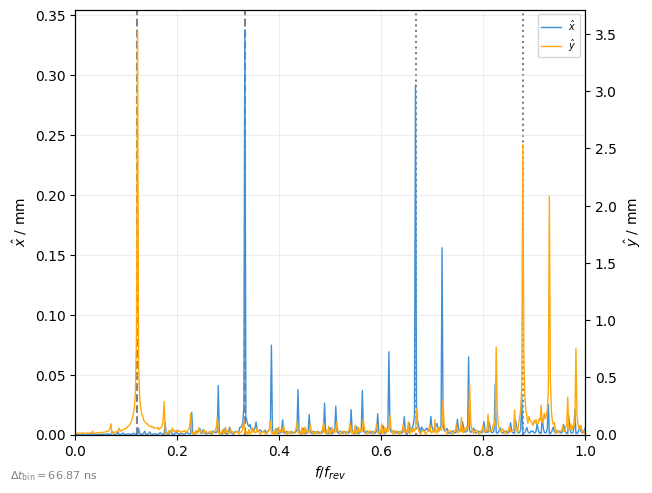

In [15]:
# select only a single particle, otherwise the tune signal is very small due to insufficient coherence of our beam
mask = (0, None)

plot = xplt.TimeFFTPlot(line.record_last_track, "x-y", relative=True, mask=mask, twiss=tw)

for Q in (tw.qx, tw.qy):
    q, h = np.modf(Q)
    plot.ax.axvline(0 + q, ls="--", color="gray", zorder=-1)
    plot.ax.axvline(1 - q, ls=":", color="gray", zorder=-1)

For reference, the spectrum of turn-by-turn positions:

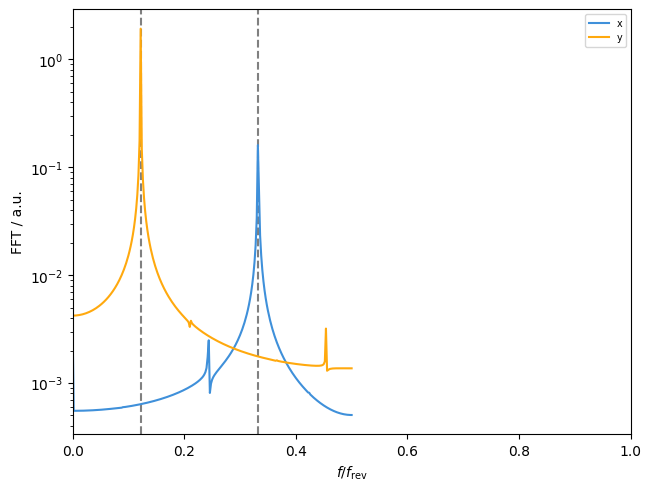

In [16]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
for xy in "xy":
    p = getattr(line.record_last_track, xy)[0, :]
    freq = np.fft.rfftfreq(len(p))
    mag = np.abs(np.fft.rfft(p))
    ax.plot(freq, mag, label=xy)
    ax.axvline(np.modf(getattr(tw, "q" + xy))[0], ls="--", color="gray", zorder=-1)
ax.legend()
ax.set(xlabel="$f/f_\\mathrm{rev}$", ylabel="FFT / a.u.", xlim=(0, 1), yscale="log");

------------
```{seealso}
- {class}`xplt.timestructure`
```